<a href="https://www.kaggle.com/code/nasiyeyldrm/bg-nbd-ve-gamma-gamma-ile-cltv-tahmini?scriptVersionId=111984482" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# BG-NBD ve Gamma-Gamma ile CLTV Tahmini

![](https://miro.medium.com/max/1200/1*8kB7crU624Xc4Gksb327mw.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flo-data-20k/flo_data_20k.csv


In [2]:
# İş Problemi
# FLO satış ve pazarlama faaliyetleri için roadmap 
# belirlemek istemektedir. Şirketin orta uzun vadeli plan 
# yapabilmesi için var olan müşterilerin gelecekte şirkete
# sağlayacakları potansiyel değerin tahmin edilmesi
# gerekmektedir.

# Veri Seti Hikayesi
# Veri seti Flo’dan son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan) 
# olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır. 

## Görev 1: Veriyi Hazırlama


In [3]:
# Adım 1: flo_data_20K.csv verisini okuyunuz.
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

df= pd.read_csv("/kaggle/input/flo-data-20k/flo_data_20k.csv")
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [4]:
# Adım 2: Aykırı değerleri baskılamak için gerekli olan outlier_thresholds ve replace_with_thresholds fonksiyonlarını tanımlayınız. 
# Not: cltv hesaplanırken frequency değerleri integer olması gerekmektedir.Bu nedenle alt ve üst limitlerini round() ile yuvarlayınız

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit)

In [5]:
# Adım 3: "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", 
# "customer_value_total_ever_online" değişkenlerinin aykırı değerleri varsa baskılayanız

columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
for col in columns:
    replace_with_thresholds(df, col)

In [6]:
# Adım 4: Omnichannel müşterilerin hem online'dan hem de offline platformlardan alışveriş yaptığını ifade etmektedir. Her bir müşterinin toplam
# alışveriş sayısı ve harcaması için yeni değişkenler oluşturunuz.

df["total_order_num"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["total_customer_value"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_order_num,total_customer_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],5.0,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",5.0,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.0,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],2.0,209.98


In [7]:
# Adım 5: Değişken tiplerini inceleyiniz. Tarih ifade eden değişkenlerin tipini date'e çeviriniz.


df.dtypes
cols = ["first_order_date", "last_order_date", "last_order_date_online" , "last_order_date_offline"]
df[cols] = df[cols].apply(pd.to_datetime)
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
total_order_num                             float64
total_customer_value                        float64
dtype: object

## Görev 2: CLTV Veri Yapısının Oluşturulması

In [8]:
# Adım 1: Veri setindeki en son alışverişin yapıldığı tarihten 2 gün sonrasını analiz tarihi olarak alınız.

import datetime as dt
df["last_order_date"].max()
today_date = dt.datetime(2021,6,2)

In [9]:
# Adım 2: customer_id, recency_cltv_weekly, T_weekly, frequency ve monetary_cltv_avg değerlerinin yer aldığı yeni bir cltv dataframe'i oluşturunuz. 
# Monetary değeri satın alma başına ortalama değer olarak, recency ve tenure değerleri ise haftalık cinsten ifade edilecek.

cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = ((df["last_order_date"]- df["first_order_date"]).astype('timedelta64[D]')) / 7
cltv_df["T_weekly"] = ((today_date - df["first_order_date"]).astype('timedelta64[D]'))/7
cltv_df["frequency"] = df["total_order_num"]
cltv_df["monetary_cltv_avg"] = df["total_customer_value"] / df["total_order_num"]

cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,30.714286,5.0,187.874000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,225.000000,21.0,95.883333
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,79.000000,5.0,117.064000
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,21.000000,2.0,60.985000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,95.571429,2.0,104.990000


## Görev 3: BG/NBD, Gamma-Gamma Modellerinin Kurulması ve CLTV’nin Hesaplanması

In [10]:
!pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.0 MB/s eta 0:00:00


In [11]:
# Adım 1: BG/NBD modelini fit ediniz

#beklenen satın alma sayılarını tahmini
#Transaction Process(Buy)+Dropout Process(Till U Die)

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df["recency_cltv_weekly"],
        cltv_df["T_weekly"])


## 3 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_3_month olarak cltv dataframe'ine ekleyiniz.


cltv_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                           cltv_df['frequency'],
                                           cltv_df['recency_cltv_weekly'],
                                           cltv_df['T_weekly'])
cltv_df.head()


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.7143,5.0000,187.8740,0.9711
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,225.0000,21.0000,95.8833,0.9821
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,79.0000,5.0000,117.0640,0.6693
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,21.0000,2.0000,60.9850,0.6983
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.5714,2.0000,104.9900,0.3955


In [12]:
# 6 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_6_month olarak cltv dataframe'ine ekleyiniz.

cltv_df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                           cltv_df['frequency'],
                                           cltv_df['recency_cltv_weekly'],
                                           cltv_df['T_weekly'])
cltv_df.head()



,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.7143,5.0000,187.8740,0.9711,1.9422
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,225.0000,21.0000,95.8833,0.9821,1.9643
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,79.0000,5.0000,117.0640,0.6693,1.3387
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,21.0000,2.0000,60.9850,0.6983,1.3967
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.5714,2.0000,104.9900,0.3955,0.7910


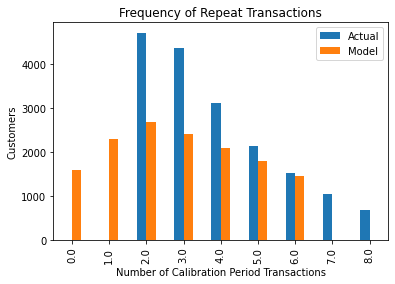

In [13]:
# Gerçek değer ile modeli karşılaştırma
plot_period_transactions(bgf)
plt.show(block=True)

In [14]:
#Adım 2: Gamma-Gamma modelini fit ediniz. Müşterilerin ortalama bırakacakları değeri tahminleyip exp_average_value olarak cltv
#dataframe'ine ekleyiniz.
#ortalama kar tahmini


ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df["monetary_cltv_avg"])

cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary_cltv_avg'])
cltv_df.sort_values("exp_average_value", ascending=False).head(10)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,8.0000,4.0000,1401.8000,1.0903,2.1805,1449.0605
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.1429,7.0000,1106.4671,0.7210,1.4421,1127.6115
15516,9083981a-f59e-11e9-841e-000d3a38a36f,63.5714,84.0000,4.0000,1090.3600,0.5737,1.1473,1127.3545
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.5714,2.0000,862.6900,0.7912,1.5823,923.6800
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57.0000,95.0000,2.0000,859.5800,0.3968,0.7936,920.3579
1853,f02473b0-43c3-11eb-806e-000d3a38a36f,17.2857,23.2857,2.0000,835.8750,0.6823,1.3646,895.0369
7936,ae4ce104-dbd4-11ea-8757-000d3a38a36f,3.7143,42.1429,3.0000,844.3467,0.6750,1.3500,883.2880
9738,3a27b334-dff4-11ea-acaa-000d3a38a36f,40.0000,41.2857,3.0000,837.0567,0.6799,1.3598,875.6741
12828,0c24fc44-2ac8-11ea-9d27-000d3a38a36f,68.0000,84.4286,2.0000,779.2650,0.4229,0.8458,834.5676
2291,26ac1432-1dd3-11ea-8bf2-000d3a38a36f,55.7143,97.8571,3.0000,780.5567,0.4592,0.9184,816.6633


In [15]:
#Adım 3: 6 aylık CLTV hesaplayınız ve cltv ismiyle dataframe'e ekleyiniz.
# Cltv değeri en yüksek 20 kişiyi gözlemleyiniz.

cltv_df["cltv"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)

cltv_df.head()




cltv_df.sort_values(by="cltv", ascending=False).head(20)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,8.0000,4.0000,1401.8000,1.0903,2.1805,1449.0605,3315.2691
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.2857,11.0000,758.0855,1.9627,3.9253,767.3606,3160.4105
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.1429,7.0000,1106.4671,0.7210,1.4421,1127.6115,1706.1692
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.7143,16.0000,501.8737,1.5619,3.1237,506.1667,1658.9627
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.4286,52.0000,166.2246,4.6447,9.2893,166.7123,1624.8745
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.5714,8.0000,601.2262,1.2618,2.5235,611.4926,1619.0748
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.5714,2.0000,862.6900,0.7912,1.5823,923.6800,1533.5062
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.1429,17.0000,259.8653,2.7699,5.5398,262.0729,1523.3079
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.8571,31.0000,228.5300,3.0758,6.1517,229.6069,1481.9906
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.7143,3.0000,743.5867,0.8687,1.7374,778.0504,1418.2907


In [16]:
#Görev 4: CLTV Değerine Göre Segmentlerin Oluşturulması
#Adım 1: 6 aylık CLTV'ye göre tüm müşterilerinizi 4 gruba (segmente) ayırınız ve grup isimlerini veri setine ekleyiniz.

cltv_df["segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

cltv_df.sort_values(by="cltv", ascending=False).head(20)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,8.0000,4.0000,1401.8000,1.0903,2.1805,1449.0605,3315.2691,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.2857,11.0000,758.0855,1.9627,3.9253,767.3606,3160.4105,A
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.1429,7.0000,1106.4671,0.7210,1.4421,1127.6115,1706.1692,A
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.7143,16.0000,501.8737,1.5619,3.1237,506.1667,1658.9627,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.4286,52.0000,166.2246,4.6447,9.2893,166.7123,1624.8745,A
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.5714,8.0000,601.2262,1.2618,2.5235,611.4926,1619.0748,A
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.5714,2.0000,862.6900,0.7912,1.5823,923.6800,1533.5062,A
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.1429,17.0000,259.8653,2.7699,5.5398,262.0729,1523.3079,A
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.8571,31.0000,228.5300,3.0758,6.1517,229.6069,1481.9906,A
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.7143,3.0000,743.5867,0.8687,1.7374,778.0504,1418.2907,A


In [17]:
#Adım 2: 4 grup içerisinden seçeceğiniz 2 grup için yönetime kısa kısa 6 aylık aksiyon önerilerinde bulununuz.

cltv_df.groupby("segment").agg({"count", "mean", "sum"})
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_cltv_weekly,19945.0000,95.2635,74.5894,0.0000,50.4286,76.5714,109.4286,433.4286
T_weekly,19945.0000,114.6147,74.7710,0.8571,74.0000,93.1429,119.5714,437.2857
frequency,19945.0000,4.9781,4.1209,2.0000,3.0000,4.0000,6.0000,57.0000
monetary_cltv_avg,19945.0000,152.0990,73.5241,22.4900,103.6533,136.9062,182.4500,1401.8000
exp_sales_3_month,19945.0000,0.5761,0.2308,0.1493,0.4333,0.5346,0.6686,4.6447
exp_sales_6_month,19945.0000,1.1522,0.4617,0.2985,0.8666,1.0691,1.3371,9.2893
exp_average_value,19945.0000,159.2385,77.0190,25.0830,108.7706,142.9166,190.4455,1449.0605
cltv,19945.0000,194.7743,132.5441,12.1031,112.1089,165.2027,239.6207,3315.2691
